# Superstore API
Time series predictions for the Superstore dataset.

## Goal
Predict sales amount for a given time frame.

# Model Selection
This notebook covers the predictive model selection.

## Imports
This notebook requires the following packages. Make sure you have them installed in order to use this notebook.

In [1]:
import datetime

import numpy as np
import pandas as pd
import statsmodels as sm

## Default variables
Define default variables for the notebook.

In [2]:
ROOT_FOLDER = os.path.split(os.getcwd()[:-1])[0]
PROCESSED_DATA_FOLDER = os.path.join(ROOT_FOLDER, "data", "processed")

## Load data
The dataset is in the `data\processed` folder.

In [3]:
DATASET_FILE_NAME = "dataset.csv"

# Load.
data = pd.read_csv(
    os.path.join(PROCESSED_DATA_FOLDER, DATASET_FILE_NAME), 
    index_col="Order Date",
    parse_dates=["Order Date"],
    )["Sales"]
print(f"Number of rows = {data.shape[0]}")

# Set frequency as daily.
data.index.freq = 'D' 

data.head()

Number of rows = 1458


Order Date
2014-01-03      16.448
2014-01-04     288.060
2014-01-05      19.536
2014-01-06    4407.100
2014-01-07      87.158
Freq: D, Name: Sales, dtype: float64

Check visually.

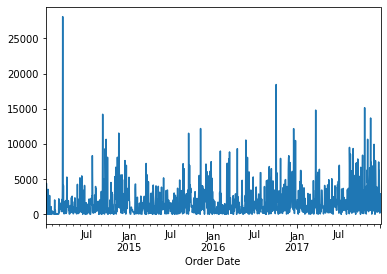

In [4]:
data.plot();

## Rolling Mean
We'll use rolling mean to smooth our data.

<AxesSubplot:xlabel='Order Date'>

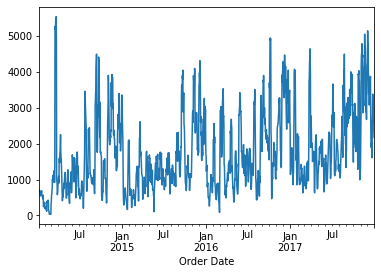

In [5]:
data = data.rolling(7).mean().dropna()
data.plot()

## Split Data

In [6]:
YEAR_DELTA = datetime.timedelta(days=365)
split_point = data.index.max() - YEAR_DELTA

train = data[data.index <= split_point]
test = data[data.index > split_point]

train.tail()

Order Date
2016-12-26    3219.114000
2016-12-27    3336.964000
2016-12-28    3454.814000
2016-12-29    3488.321429
2016-12-30    2603.738143
Freq: D, Name: Sales, dtype: float64

## Stationary

In [7]:
from statsmodels.tsa.stattools import adfuller

labels = ['ADF Test Statistic', 'P-Value','Number of Lags Used','Number of Observations Used']
results = adfuller(train)

results = pd.DataFrame({label: result for label, result in zip(labels, results)}, index=["Results"])

if results["P-Value"][0] <= 0.05:
    print("Strong evidence against the null hypothesis (Ho), reject the null hypothesis. Data has no unit root and is stationary.")
else:
    print("Weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary.")

results.transpose()

Strong evidence against the null hypothesis (Ho), reject the null hypothesis. Data has no unit root and is stationary.


,Results
ADF Test Statistic,-4.301157
P-Value,0.000442
Number of Lags Used,21.000000
Number of Observations Used,1065.000000


## Autocorrelation

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

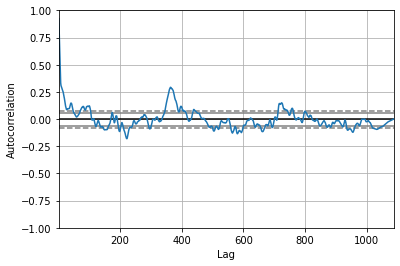

In [8]:
pd.plotting.autocorrelation_plot(train)

## ACF & PACF

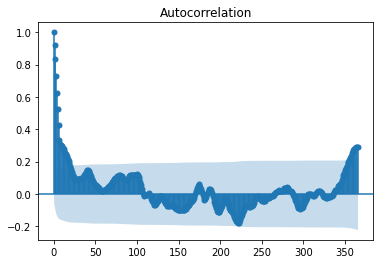

In [9]:
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(train, lags=365);

/home/mcouto/projects/superstore-api/venv/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1434: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


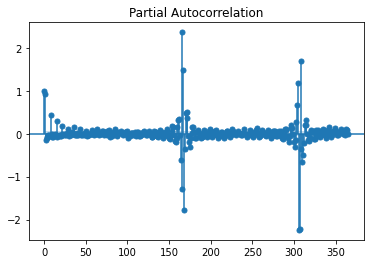

In [10]:
from statsmodels.graphics.tsaplots import plot_pacf

plot_pacf(train, lags=365);

## Modelling
Over the next cells we will check different models on our data.

In [11]:
def score(true, pred):
    """ Calculate root mean squared error and plot. """
    # Avoid inplace changes.
    pred = pred.copy()
    true = true.copy()

    # Change names.
    pred.name = "Pred"
    true.name = "True"

    # Plot
    pred.plot(legend=True)
    true.plot(legend=True)
    
    # Calculate metric.
    return np.mean(np.sqrt(np.square(true - pred)))


def fit_predict_score(model, test, *args, **kwargs):
    """ Fit, predict and score model. """
    model = model.fit(*args, **kwargs)
    pred = model.predict(start=test.index.min(), end=test.index.max())
    return score(true=test, pred=pred)

### Baseline

In [12]:
train.mean()

1593.8668905375212

### Autoregression (AR)

CPU times: user 1.03 s, sys: 66.6 ms, total: 1.1 s
Wall time: 1.05 s


914.7924729879603

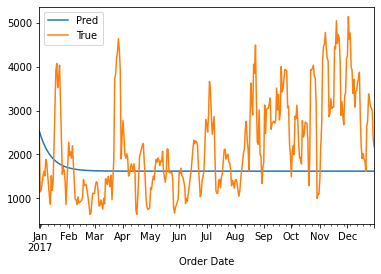

In [13]:
%%time

from statsmodels.tsa.ar_model import AutoReg

model = AutoReg(train, lags=1, old_names=False)
fit_predict_score(model, test)

### Moving Average (MA)

/home/mcouto/projects/superstore-api/venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
CPU times: user 2.32 s, sys: 858 ms, total: 3.18 s
Wall time: 1.84 s


906.9975667993264

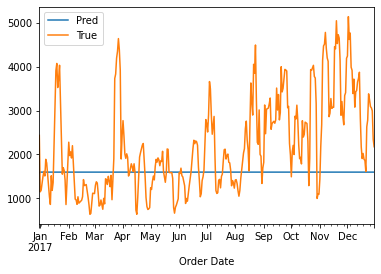

In [14]:
%%time

from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(train, order=(0, 0, 1))
fit_predict_score(model, test)

### Autoregressive Moving Average (ARMA)

909.7662758549395

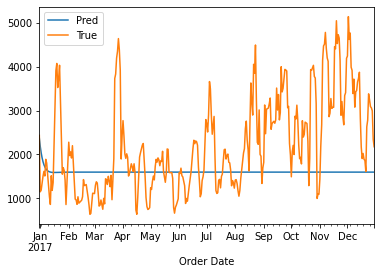

In [15]:
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(train, order=(2, 0, 1))
fit_predict_score(model, test)

### Autoregressive Integrated Moving Average (ARIMA)

CPU times: user 1.18 s, sys: 670 ms, total: 1.85 s
Wall time: 1.04 s


944.1687447590613

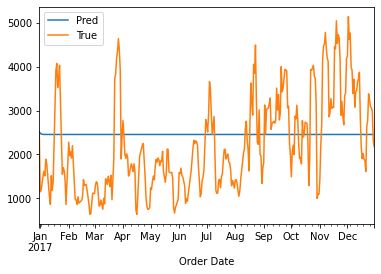

In [16]:
%%time

from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(train, order=(1, 1, 1))
fit_predict_score(model, test)

### Seasonal Autoregressive Integrated Moving-Average (SARIMA)

CPU times: user 1.04 s, sys: 513 ms, total: 1.55 s
Wall time: 1.07 s


944.1687447590613

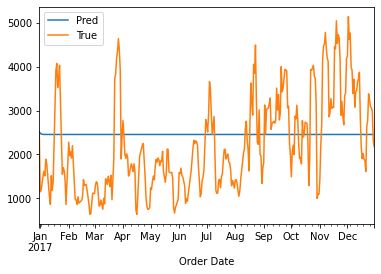

In [17]:
%%time

from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(train, order=(1, 1, 1), seasonal_order=(0, 0, 0, 0))
fit_predict_score(model, test, disp=False)